# 28회 ADP 복원 

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import scipy.stats as stats

# 기계학습 (50점)

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/dipam7/student-grade-prediction?resource=download 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv
- 데이터 설명 : 학생의 다양한 주변 환경에 따른 결석 등급 (absences)
    - sex : 성별 (F : 여성 / M :남성)
    - age : 나이
    - pstatus : 부모와 동거 유무 (T : 동거중 , A : 별거)
    - medu : 어머니 교육(0 - 없음, 1 - 초등 교육(4학년), 2 - 5~9학년, 3 - 중등 교육 또는 4 - 고등 교육)
    - fedu : 아버지 교육(0 - 없음, 1 - 초등 교육(4학년), 2 - 5 - 9학년, 3 - 중등 교육 또는 4 - 고등 교육)
    - guardian : 학생의 보호자
    - traveltime : 집에서 학교까지 이동 시간(1 - <15분, 2 - 15 - 30분, 3 - 30분 - 1시간, 또는 4 - >1시간)
    - studytime : 주간 학습 시간(1 - <2시간, 2 - 2 - 5시간, 3 - 5 - 10시간 또는 4 - >10시간)
    - failures : 과거 클래스 실패 수(n if 1<=n<3, 그렇지 않으면 4)
    - freetime : 방과 후 자유 시간(숫자: 1 - 매우 낮음에서 5 - 매우 높음)
    - famrel : 가족 관계의 질(숫자: 1 - 매우 나쁨에서 5 - 훌륭함)
    - absences : 학교 결석 횟수등급 (0~5, 높은 숫자일수록 많은 결석 횟수)

In [22]:
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv")
df.head()

,sex,age,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel,absences
0,F,18,A,4,4,mother,2,2,0,3,4,2
1,F,17,T,1,1,father,1,2,0,3,5,1
2,F,15,T,1,1,mother,1,2,3,3,4,3
3,F,15,T,4,2,mother,1,3,0,2,3,0
4,F,16,T,3,3,father,1,2,0,3,4,1


## 1-1. EDA를 진행하고 (+시각화) , 차원축소의 필요성이 있는지 확인 (5점)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sex         395 non-null    object
 1   age         395 non-null    int64 
 2   pstatus     395 non-null    object
 3   medu        395 non-null    int64 
 4   fedu        395 non-null    int64 
 5   guardian    395 non-null    object
 6   traveltime  395 non-null    int64 
 7   studytime   395 non-null    int64 
 8   failures    395 non-null    int64 
 9   freetime    395 non-null    int64 
 10  famrel      395 non-null    int64 
 11  absences    395 non-null    int64 
dtypes: int64(9), object(3)
memory usage: 37.2+ KB


In [24]:
cat_col = ['sex', 'pstatus', 'guardian']
num_col = list(df.columns.difference(cat_col))

In [25]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in cat_col:
    df[col] = encoder.fit_transform(df[col])
df
# 변환된 label
# sex
# 0: 여성 (F), 1: 남성 (M)
# pstatus
# 0: 동거 중 (T), 1: 별거 (A)
# guardian
# 0: father, 1: mother, 2: other

,sex,age,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel,absences
0,0,18,0,4,4,1,2,2,0,3,4,2
1,0,17,1,1,1,0,1,2,0,3,5,1
2,0,15,1,1,1,1,1,2,3,3,4,3
3,0,15,1,4,2,1,1,3,0,2,3,0
4,0,16,1,3,3,0,1,2,0,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,20,0,2,2,2,1,2,2,5,5,4
391,1,17,1,3,1,1,2,1,0,4,2,1
392,1,21,1,1,1,2,1,1,3,5,5,1
393,1,18,1,3,2,1,3,1,0,4,4,0


<답안>
Barplot으로 시각화해본 결과, 분포가 비교적 균일한 변수도 있으나, 일부 변수에서는 비율의 차이가 크게 나타났다.
부모의 동거 유형 변수에서는 동거중인 학생이 훨씬 많았으며, 학생의 보호자도 mother의 비율이 높았다.
또한, 많은 학생들의 결석 일수는 0회이지만, 일부 학생들의 경우 학사경고를 받은 이력이 있다.
구간 수치형으로 측정된 변수들을 조금 더 자세히 살펴보기 위해, 수치 변수들의 boxplot을 그려 보았다.
가족들과의 관계는 대체로 좋은 학생들이 많이 있으며, 공부 시간과 통학 시간은 대체로 적은 편이다.


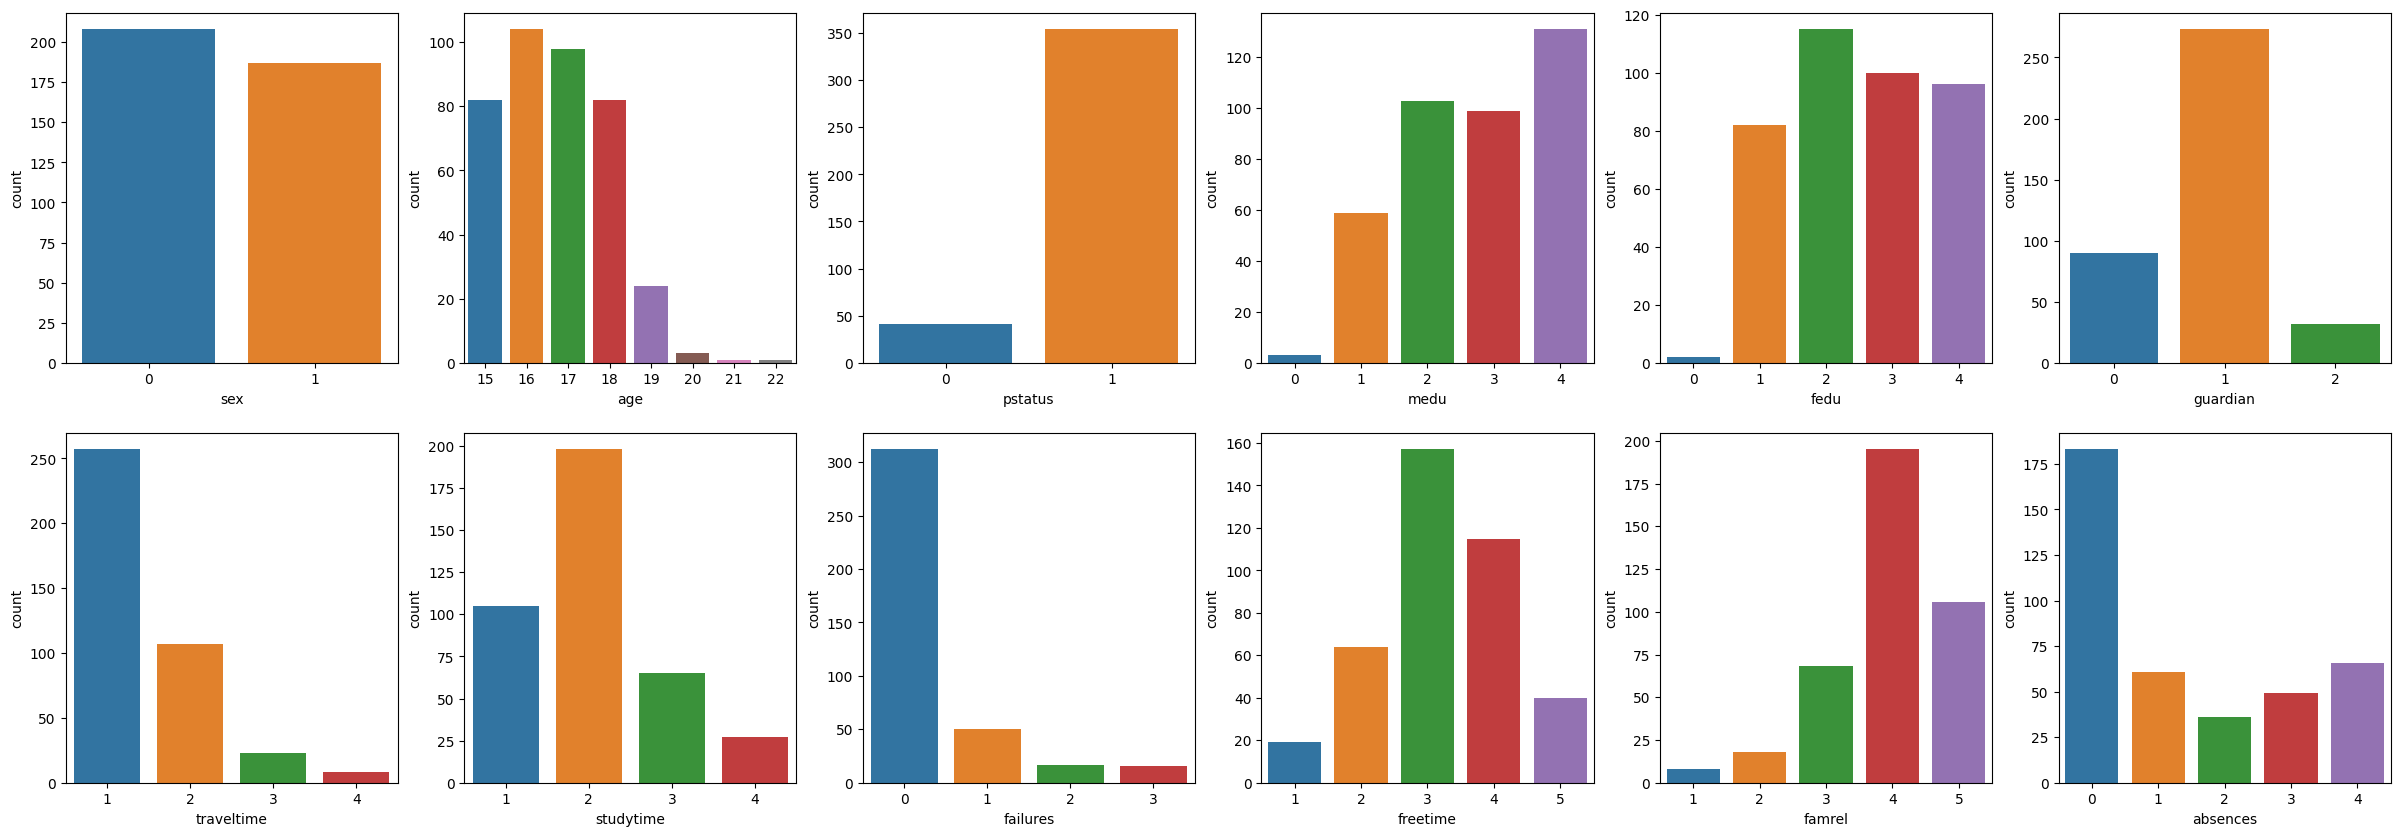

In [26]:
fig, axes = plt.subplots(nrows=len(df.columns)//6, ncols=len(df.columns)//(len(df.columns)//6), figsize=(30, 10))
for i, col in enumerate(df.columns):
    ax_col = i%6
    ax_row = i//6
    sns.countplot(x=col, data=df, ax=axes[ax_row, ax_col])
    
print('<답안>')
print('Barplot으로 시각화해본 결과, 분포가 비교적 균일한 변수도 있으나, 일부 변수에서는 비율의 차이가 크게 나타났다.')
print('부모의 동거 유형 변수에서는 동거중인 학생이 훨씬 많았으며, 학생의 보호자도 mother의 비율이 높았다.')
print('또한, 많은 학생들의 결석 일수는 0회이지만, 일부 학생들의 경우 학사경고를 받은 이력이 있다.')
print('구간 수치형으로 측정된 변수들을 조금 더 자세히 살펴보기 위해, 수치 변수들의 boxplot을 그려 보았다.')
print('가족들과의 관계는 대체로 좋은 학생들이 많이 있으며, 공부 시간과 통학 시간은 대체로 적은 편이다.')

In [27]:
df.corr(method='spearman')

,sex,age,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel,absences
sex,1.000000,-0.045776,0.023443,0.081252,0.037877,-0.070057,0.045191,-0.336825,0.045271,0.229472,0.066286,-0.009005
age,-0.045776,1.000000,0.041898,-0.161294,-0.149596,0.233634,0.109804,0.031557,0.236464,0.000302,0.031380,0.196475
pstatus,0.023443,0.041898,1.000000,-0.115923,-0.087516,-0.110018,0.027536,0.017050,0.008861,0.049030,-0.001811,-0.134104
medu,0.081252,-0.161294,-0.115923,1.000000,0.631577,-0.012406,-0.147849,0.063498,-0.242373,0.028493,0.012361,0.110095
fedu,0.037877,-0.149596,-0.087516,0.631577,1.000000,-0.133022,-0.154454,0.018429,-0.236616,-0.017132,0.011400,0.023772
guardian,-0.070057,0.233634,-0.110018,-0.012406,-0.133022,1.000000,-0.001291,0.033462,0.154114,0.049865,0.048813,0.156150
traveltime,0.045191,0.109804,0.027536,-0.147849,-0.154454,-0.001291,1.000000,-0.105969,0.079917,-0.022279,-0.038656,-0.035393
studytime,-0.336825,0.031557,0.017050,0.063498,0.018429,0.033462,-0.105969,1.000000,-0.157633,-0.131321,0.058141,-0.056629
failures,0.045271,0.236464,0.008861,-0.242373,-0.236616,0.154114,0.079917,-0.157633,1.000000,0.088058,-0.051389,0.126691
freetime,0.229472,0.000302,0.049030,0.028493,-0.017132,0.049865,-0.022279,-0.131321,0.088058,1.000000,0.143142,0.031032


<답안>
일부 변수(medu, fedu)의 경우 순위상관계수가 0.63으로 약간 높게 나타났으나 다중공선성을 걱정해야 할 정도는 아닌 것으로 판단되며, 나머지 변수들의 상관관계는 대체로 거의 없는 것으로 보인다.
차원 축소가 반드시 필요한 데이터는 아닌 것으로 생각되어, 차원 축소는 진행하지 않고 원본 데이터를 그대로 사용하였다.


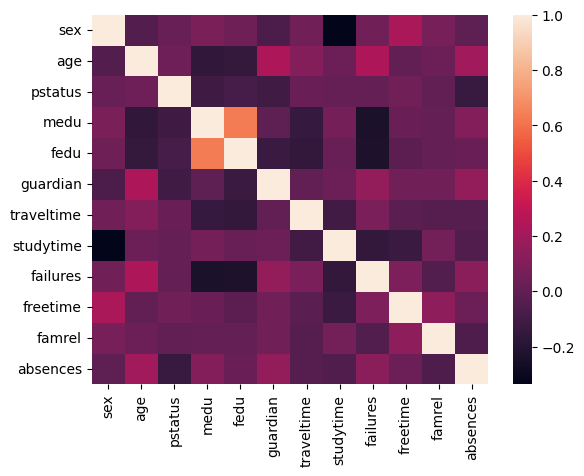

In [28]:
sns.heatmap(df.corr(method='spearman'))

print('<답안>')
print('일부 변수(medu, fedu)의 경우 순위상관계수가 0.63으로 약간 높게 나타났으나 다중공선성을 걱정해야 할 정도는 아닌 것으로 판단되며, 나머지 변수들의 상관관계는 대체로 거의 없는 것으로 보인다.')
print('차원 축소가 반드시 필요한 데이터는 아닌 것으로 생각되어, 차원 축소는 진행하지 않고 원본 데이터를 그대로 사용하였다.')

In [29]:
from sklearn.decomposition import PCA

In [ ]:
# 주성분 추출
pca = PCA(n_components=len(df.columns))
pca_fit = pca.fit(df)

print("고유 값 : ", pca.singular_values_)
print("분산 설명력: ", pca.explained_variance_ratio_)

## 1-2. 데이터 품질 개선을 위한 방법이 있는지 찾고 데이터셋을 재생성하라 (5점)

In [31]:
df['studytime_cat'] = np.where(df['studytime'] > 0, 1, 0)
df['traveltime_cat'] = np.where(df['traveltime'] > 0, 1, 0)
df.drop(['studytime', 'traveltime'], axis=1, inplace=True)

x = df.drop('absences', axis=1)
y = df['absences']

from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(x, y)

In [34]:
print('<답안>')
print('데이터셋에서 일부 이상치가 보이고 있으며, 일부 변수의 skewness가 높아 보인다.')
print('이를 해결하기 위해, studytime, traveltime 변수를 높음/낮음으로 재범주화하고, failure 변수의 경우 있음/없음으로 재범주화를 진행하였다.')
print('또한, absence의 등급 별 비율에 차이가 있으므로, Over sampling을 진행하여 보정하였다.')
y_over.value_counts()

<답안>
데이터셋에서 일부 이상치가 보이고 있으며, 일부 변수의 skewness가 높아 보인다.
이를 해결하기 위해, studytime, traveltime 변수를 높음/낮음으로 재범주화하고, failure 변수의 경우 있음/없음으로 재범주화를 진행하였다.
또한, absence의 등급 별 비율에 차이가 있으므로, Over sampling을 진행하여 보정하였다.


absences
2    183
1    183
3    183
0    183
4    183
Name: count, dtype: int64

## 1-3. 1.2에서 제시한 방법이 데이터 과적합이 된다는 가정하에 어떻게 해결할 수 있을지 2가지 개선안 제시, 각방법들의 장단점 기술 (10점)

In [117]:
print('<답안>')
print('1-2 에서 제시한 oversampling 방법은 같은 x 데이터를 복제하는 것이기 때문에 과적합의 위험이 있다. Oversampling 대신 SMOTE 기법과 ADASYN 기법을 사용하면 과적합의 위험을 덜 수 있다.')
print('SMOTE는 소수 레이블의 값과 K-NN 사이에 임의의 새로운 데이터 생성하는 방법으로, 상대적으로 적은 카테고리의 Recall 상승에 최적이며, ADASYN은 샘플링 개수를 데이터 위치에 따라 다르게 설정하여, 모델이 혼동하기 쉬운 부분에 데이터를 추가함으로써 적은 데이터 생성만으로도 효율적으로 성능을 높일 수 있다.')
print('두 방법 모두 임의의 데이터를 생성하는 기법이므로, 모델의 정확도가 Oversampling에 비해 낮을 수 있다.')
print('여기에서는 catagorical과 numeric 데이터가 섞여 있으므로, SMOTE 기법의 변형인 SMOTE-NC(Nominal and Continuous)를 사용하여 Sampling을 진행하였다.')

<답안>
1-2 에서 제시한 oversampling 방법은 같은 x 데이터를 복제하는 것이기 때문에 과적합의 위험이 있다. Oversampling 대신 SMOTE 기법과 ADASYN 기법을 사용하면 과적합의 위험을 덜 수 있다.
SMOTE는 소수 레이블의 값과 K-NN 사이에 임의의 새로운 데이터 생성하는 방법으로, 상대적으로 적은 카테고리의 Recall 상승에 최적이며, ADASYN은 샘플링 개수를 데이터 위치에 따라 다르게 설정하여, 모델이 혼동하기 쉬운 부분에 데이터를 추가함으로써 적은 데이터 생성만으로도 효율적으로 성능을 높일 수 있다.
두 방법 모두 임의의 데이터를 생성하는 기법이므로, 모델의 정확도가 Oversampling에 비해 낮을 수 있다.
여기에서는 catagorical과 numeric 데이터가 섞여 있으므로, SMOTE 기법의 변형인 SMOTE-NC(Nominal and Continuous)를 사용하여 Sampling을 진행하였다.


In [119]:
from imblearn.over_sampling import SMOTENC

smote_sample = SMOTENC(categorical_features=cat_col) 
x_sm, y_sm = smote_sample.fit_resample(x, y)
y_sm.value_counts()

absences
2    183
1    183
3    183
0    183
4    183
Name: count, dtype: int64

## 2-1. 1-2 데이터셋을 기준으로 random forest, neural network , lightgbm 3가지 방식으로 학교 결석 횟수등급을 예측하는 모델을 만들어라, f1 score로 모델을 평가하라 (5점)

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2, stratify=y_sm)

rf_clf = RandomForestClassifier()
nn_clf = MLPClassifier()
gbm_clf = LGBMClassifier()

rf_clf.fit(x_train, y_train)
nn_clf.fit(x_train, y_train)
gbm_clf.fit(x_train, y_train)

rf_pred = rf_clf.predict(x_test)
nn_pred = nn_clf.predict(x_test)
gbm_pred = gbm_clf.predict(x_test)

rf_pred = np.where(rf_pred >=4.5, 5, np.where(rf_pred >=3.5, 4, np.where(rf_pred >=2.5, 3, np.where(rf_pred >=1.5, 2, np.where(rf_pred >=0.5, 1, 0)))))
nn_pred = np.where(nn_pred >=4.5, 5, np.where(nn_pred >=3.5, 4, np.where(nn_pred >=2.5, 3, np.where(nn_pred >=1.5, 2, np.where(nn_pred >=0.5, 1, 0)))))
gbm_pred = np.where(gbm_pred >=4.5, 5, np.where(gbm_pred >=3.5, 4, np.where(gbm_pred >=2.5, 3, np.where(gbm_pred >=1.5, 2, np.where(gbm_pred >=0.5, 1, 0)))))

In [122]:
print('<답안>')
print(f"Random Forest 모델의 F1-score는 {round(f1_score(rf_pred, y_test, average='macro'), 3)}, Neural Network는 {round(f1_score(nn_pred, y_test, average='macro'), 3)}, LightGBM은 {round(f1_score(gbm_pred, y_test, average='macro'), 3)}으로, LightGBM 모델의 성능이 가장 우수한 것으로 나타났다.")

<답안>
Random Forest 모델의 F1-score는 0.584, Neural Network는 0.317, LightGBM은 0.598으로, LightGBM 모델의 성능이 가장 우수한 것으로 나타났다.


## 2-2. hard voting, soft voting에 대한 장단점을 설명하고 2-1의 3가지 모델로 구현하라. 두 방식의 f1-score를 비교하라 (10점)

In [ ]:
from sklearn.ensemble import VotingClassifier

### hard voting
voting_clf_hard = VotingClassifier(estimators=[('rf', rf_clf), ('nn', nn_clf), ('gbm', gbm_clf)], voting='hard')
voting_clf_hard.fit(x_train, y_train)

### soft voting
voting_clf_soft = VotingClassifier(estimators=[('rf', rf_clf), ('nn', nn_clf), ('gbm', gbm_clf)], voting='soft')
voting_clf_soft.fit(x_train, y_train)

hard_pred = voting_clf_hard.predict(x_test)
hard_pred = np.where(hard_pred >=4.5, 5, np.where(hard_pred >=3.5, 4, np.where(hard_pred >=2.5, 3, np.where(hard_pred >=1.5, 2, np.where(hard_pred >=0.5, 1, 0)))))

soft_pred = voting_clf_soft.predict(x_test)
soft_pred = np.where(soft_pred >=4.5, 5, np.where(soft_pred >=3.5, 4, np.where(soft_pred >=2.5, 3, np.where(soft_pred >=1.5, 2, np.where(soft_pred >=0.5, 1, 0)))))

In [124]:
print('<답안>')
print('Hard voting과 Soft voting은 각 모델의 예측 결과를 투표를 통해 결정하는 앙상블 방법이다. Hard Voting은 가장 많이 득표한 class로 예측하며, Soft Voting은 각 모델의 예측 확률을 계산하여, 가장 높은 확률을 가지는 class로 예측한다.')
print('Hard voting은 클래스의 확률을 구할 수 없는 경우에도 사용할 수 있고, ㅎ 예측 정확도와 예측 반응속도가 상대적으로 떨어지고, Soft voting은 상대적으로 예측 정확도가 높은 것으로 알려져 있으나, 각 클래스의 확률을 구할 수 없는 경우 사용할 수 없다.')
print(f"모델링 결과, Hard voting 모델의 F1-score는 {round(f1_score(hard_pred, y_test, average='macro'), 3)}, Soft voting은 {round(f1_score(soft_pred, y_test, average='macro'), 3)}으로 Soft voting 모델의 성능이 약간 더 좋은 것으로 나타났다.")

<답안>
Hard voting과 Soft voting은 각 모델의 예측 결과를 투표를 통해 결정하는 앙상블 방법이다. Hard Voting은 가장 많이 득표한 class로 예측하며, Soft Voting은 각 모델의 예측 확률을 계산하여, 가장 높은 확률을 가지는 class로 예측한다.
Hard voting은 클래스의 확률을 구할 수 없는 경우에도 사용할 수 있고, ㅎ 예측 정확도와 예측 반응속도가 상대적으로 떨어지고, Soft voting은 상대적으로 예측 정확도가 높은 것으로 알려져 있으나, 각 클래스의 확률을 구할 수 없는 경우 사용할 수 없다.
모델링 결과, Hard voting 모델의 F1-score는 0.576, Soft voting은 0.579으로 Hard voting 모델의 성능이 약간 더 좋은 것으로 나타났다.


## 2-3. 총 5개 모델(RF, NN, LGBM, 하드보팅, 소프트보팅) 중 실시간 온라인 시스템에 가장 적합한 모델과 선정이유를 객관적으로 제시하라 (5점)

In [125]:
print('<답안>')
print('모델 서빙에는 모델의 성능이 가장 우선시되지만, 실시간 온라인 시스템의 경우 여기에 더해 예측 수행 속도가 가장 빠른 모델이 적합하다. 모델의 성능 0.397로 좋지 않은 Neural Network 모델은 제외하고, 나머지 모델에 대해 test data로 각 모델의 예측 수행 속도를 비교해보고, 가장 속도가 빠른 모델을 선정하였다.')
print('')

from timeit import timeit

print(f'Random Forest model의 예측 수행 속도: {timeit("rf_clf.predict(x_test)", number=2, globals=globals())}')
print(f'LightGBM model의 예측 수행 속도: {timeit("gbm_clf.predict(x_test)", number=2, globals=globals())}')
print(f'Hard voting model의 예측 수행 속도: {timeit("voting_clf_hard.predict(x_test)", number=2, globals=globals())}')
print(f'Soft voting model의 예측 수행 속도: {timeit("voting_clf_soft.predict(x_test)", number=2, globals=globals())}')
print('LightGBM 모델의 성능은 0.598로 Voting 모델들보다 오히려 성능이 더 좋고, 예측 반응 속도도 두 배 정도 빠르기 때문에 실시간 온라인 시스템에 가장 적합하다.')

<답안>
모델 서빙에는 모델의 성능이 가장 우선시되지만, 실시간 온라인 시스템의 경우 여기에 더해 예측 수행 속도가 가장 빠른 모델이 적합하다. 모델의 성능 0.397로 좋지 않은 Neural Network 모델은 제외하고, 나머지 모델에 대해 test data로 각 모델의 예측 수행 속도를 비교해보고, 가장 속도가 빠른 모델을 선정하였다.

Random Forest model의 예측 수행 속도: 0.024642375001349137
LightGBM model의 예측 수행 속도: 0.005964083999060676
Hard voting model의 예측 수행 속도: 0.020569500000419794
Soft voting model의 예측 수행 속도: 0.017223749999175197
LightGBM 모델의 성능은 0.598로 Voting 모델들보다는 약간 나쁘지만, 예측 반응 속도가 두 배 정도 빠르기 때문에, 실시간 온라인 시스템에 가장 적합하다.


## 3-1. 적정 모델과 선정 및 모델링 과정에서 추가적으로 고려해볼 만한 사항은? (5점)

In [126]:
print('<답안>')
print('지금 모델링 과정에서는 하이퍼파라미터 튜닝이 진행되지 않았는데, 이를 수행한다면 조금 더 높은 성능을 기대해볼 수 있을 것이다.')
print('그리고 Voting 수행 시, 성능이 좋은 모델의 예측에 가중치를 부여한다면 Voting 모델링의 예측 성능이 더 개선될 여지가 있다.')
print('또한, Train/Test set 분할 시 HoldOut 방법을 사용하였는데, Cross Validation을 적용한다면 일반화가 더 용이한 모델을 기대해볼 수 있다.')

<답안>
지금 모델링 과정에서는 하이퍼파라미터 튜닝이 진행되지 않았는데, 이를 수행한다면 조금 더 높은 성능을 기대해볼 수 있을 것이다.
그리고 Voting 수행 시, 성능이 좋은 모델의 예측에 가중치를 부여한다면 Voting 모델링의 예측 성능이 더 개선될 여지가 있다.
또한, Train/Test set 분할 시 HoldOut 방법을 사용하였는데, Cross Validation을 적용한다면 일반화가 더 용이한 모델을 기대해볼 수 있다.


## 3-2. 모델을 학교 시스템에 적용하여 활용하려한다. 모델 적용 및 운영과정에서 고려해볼 만한 사항? (5점)

In [107]:
print('<답안>')
print('2-3에서는 실시간 온라인 시스템을 가정하였으나, 결석 등급 예측의 경우 즉시 결과를 내놓아야 하는 실시간 예측과는 거리가 멀다. 그리고 모델링에 사용되는 데이터는 수집에 시일이 걸리는 데이터로 보인다.')
print('특정 학생의 결석 등급을 바로 예측하는 실시간 시스템보다는, 여러 학생의 결석 등급 데이터를 모아 한번에 예측하는 배치 시스템을 우선 고려하여야 한다.')
print('또한, 학생의 특성은 시간이 지남에 따라 변한다. 따라서 해당 모델은 데이터의 분포가 변하는 Data Drift의 필연적 발생이 예상된다. drift가 발생할 경우 모델의 예측 성능이 떨어지기 때문에, 주기적으로 데이터를 수집/재학습하여 모델을 현행화하는 시스템 또한 필요하다.')

<답안>
2-3에서는 실시간 온라인 시스템을 가정하였으나, 결석 등급 예측의 경우 즉시 결과를 내놓아야 하는 실시간 예측과는 거리가 멀다. 그리고 모델링에 사용되는 데이터는 수집에 시일이 걸리는 데이터로 보인다.
특정 학생의 결석 등급을 바로 예측하는 실시간 시스템보다는, 여러 학생의 결석 등급 데이터를 모아 한번에 예측하는 배치 시스템을 우선 고려하여야 한다.
또한, 학생의 특성은 시간이 지남에 따라 변한다. 따라서 해당 모델은 데이터의 분포가 변하는 Data Drift의 필연적 발생이 예상된다. drift가 발생할 경우 모델의 예측 성능이 떨어지기 때문에, 주기적으로 데이터를 수집/재학습하여 모델을 현행화하는 시스템 또한 필요하다.


# 통계 (50점)

# 4번 데이터
- 데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p4_.csv
- status : 생존 여부 (death: 죽음 / event lost: 생존)
- company : 회사구분

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p4_.csv')
df.head()

,time(month),status,company
0,1,event lost,X
1,2,event lost,X
2,3,event lost,X
3,4,event lost,X
4,5,event lost,X


In [10]:
# object to int to apply kmf
df.status = np.where(df.status=="death", 1, 0).astype(int)

## 4-1 Kaplan Meier 방법 사용 생존분석 수행. 회사부품별 25, 35, 45 개월에서의 생존 확률 (소숫점 3자리 ,5점)

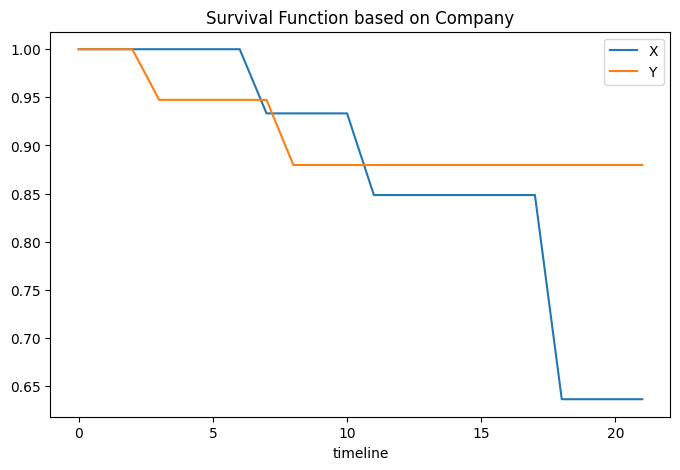

In [40]:
company_x = df[df.company=='X']
company_y = df[df.company=='Y']

ax = plt.subplot()
kmf_x = KaplanMeierFitter()
kmf_y = KaplanMeierFitter()

kmf_x.fit(durations=company_x['time(month)'], event_observed=company_x['status'], label='X')
kmf_x.survival_function_.plot(figsize=(8, 5), ax=ax)
kmf_y.fit(durations=company_y['time(month)'], event_observed=company_y['status'], label='Y')
kmf_y.survival_function_.plot(figsize=(8, 5), ax=ax)
plt.title('Survival Function based on Company')
plt.show();

In [36]:
print('<답안>')
print(f'Company X의 25개월 생존 확률: {round(kmf_x.predict(25.0), 3)}')
print(f'Company X의 35개월 생존 확률: {round(kmf_x.predict(35.0), 3)}')
print(f'Company X의 45개월 생존 확률: {round(kmf_x.predict(45.0), 3)}')

print(f'Company Y의 25개월 생존 확률: {round(kmf_y.predict(25.0), 3)}')
print(f'Company Y의 35개월 생존 확률: {round(kmf_y.predict(35.0), 3)}')
print(f'Company Y의 45개월 생존 확률: {round(kmf_y.predict(45.0), 3)}')

<답안>
Company X의 25개월 생존 확률: 0.636
Company X의 35개월 생존 확률: 0.636
Company X의 45개월 생존 확률: 0.636
Company Y의 25개월 생존 확률: 0.88
Company Y의 35개월 생존 확률: 0.88
Company Y의 45개월 생존 확률: 0.88


## 4-2 두 회사간 생존시간 차이를 log-rank 방식으로 검정하시오. 가설설정, 통계량, 귀무가설 기각여부 판단(10점)

In [39]:
### Log rank test
output = logrank_test(durations_A = company_x['time(month)'],
                      durations_B = company_x['time(month)'],
                      event_observed_A = company_y['status'],
                      event_observed_B = company_y['status'])
output.print_summary

print('<답안>')
print('H0: 두 회사의 부품 생존시간에는 차이가 없다')
print('H1: 두 회사의 부품 생존시간에는 차이가 있다')
print('카이제곱 통계량: 0.00')
print('P-value는 1.00으로 귀무가설을 기각할 수 없다. 따라서 두 회사의 부품 생존시간에는 차이가 있다고 볼 통계적 근거가 부족하다')

<답안>
H0: 두 회사의 부품 생존시간에는 차이가 없다
H1: 두 회사의 부품 생존시간에는 차이가 있다
카이제곱 통계량: 0.00
P-value는 1.00으로 귀무가설을 기각할 수 없다. 따라서 두 회사의 부품 생존시간에는 차이가 있다고 볼 통계적 근거가 부족하다


# 5번 데이터
- 데이터 url: https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p5_.csv 
- data형식
    - 한 유저가 시식 전 물건 구매의사 유,무와 시식 후 구매의사 유,무에 대한 응답을 나타낸 데이터
    - {시식전} _ {구매의사 유 or 무} __ {시식후} _ {구매의사 유 or 무}


In [41]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p5_.csv')
df.head()

,data,userId
0,시식전_유__시식후_유,user_1
1,시식전_유__시식후_유,user_2
2,시식전_유__시식후_유,user_3
3,시식전_유__시식후_유,user_4
4,시식전_유__시식후_유,user_5


In [58]:
### 데이터 변환
pur_array = np.zeros(4).reshape(2, 2)
for i in df.index:
    user_data = df.loc[i].str.split('__')[0]
    before = user_data[0].split('_')[1]
    after = user_data[1].split('_')[1]

    if before=='유' and after=='유':
        pur_array[1, 1] += 1
    elif before=='유' and after=='무':
        pur_array[1, 0] += 1
    
    if before=='무' and after=='유':
        pur_array[0, 1] += 1
    else:
        pur_array[0, 0] += 1

## 5-1 시식여부가 구매의사에 영향을 주는지 가설을 설정하시오(5점)

In [42]:
print('<답안>')
print('H0: 시식 여부는 구매의사에 영향을 주지 않는다')
print('H1: 시식 여부가 구매의사에 영향을 준다')

<답안>
H0: 시식 여부는 구매의사에 영향을 주지 않는다
H1: 시식 여부가 구매의사에 영향을 준다


## 5-2 검정하고 결과를 분석하시오(5점)

In [62]:
from statsmodels.stats.contingency_tables import mcnemar

print(mcnemar(pur_array, exact=True, correction=True))
print('<답안>')
print('검정통계량 8.0, p-value 0.108로 귀무가설을 기각할 수 없다. 따라서 시식 여부는 구매 의사에 영향을 준다고 볼 통계적 근거가 없다')

pvalue      0.10775214433670044
statistic   8.0
<답안>
검정통계량 8.0, p-value 0.108로 귀무가설을 기각할 수 없다. 따라서 시식 여부는 구매 의사에 영향을 준다고 볼 통계적 근거가 없다


# 6번 데이터
- 데이터 url: https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p6.csv 

## 6-1 A,B 지역 학생의 점수에 차이가 있는지 가설을 설정하고 검정하시오 (10점)

In [64]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p6.csv')
df.head()

,score,school_name,ID
0,91.0,A,1
1,NaN,A,2
2,NaN,A,3
3,NaN,A,4
4,NaN,A,5


In [65]:
sch_a = df[df.school_name=='A']
sch_b = df[df.school_name=='B']

In [70]:
sch_a.dropna(inplace=True)

/var/folders/1m/4rsksycx3qvf5nrg_td3lpxw0000gn/T/ipykernel_12546/3453737128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sch_a.dropna(inplace=True)


In [78]:
print('<답안>')
print('이 데이터는 독립적인 두 집단의 차이를 검정하는 문제로 볼 수 있다.')
print('본격적으로 검정을 시행하기 전에, 두 집단의 분포가 정규성을 만족하는지 확인한다.')
print('H0: 집단이 정규분포를 따른다')
print('H1: 집단이 정규분포를 따르지 않는다')

print(f'A 지역 학생의 점수에 대한 정규성 검정 결과: {stats.shapiro(sch_a.score)}')
print(f'B 지역 학생의 점수에 대한 정규성 검정 결과: {stats.shapiro(sch_b.score)}')
print('A 지역 학생의 점수는 p-value 0.12로 귀무가설을 기각하지 않지만, B 지역 학생의 점수는 p-value 0.025로 귀무가설을 기각한다. 즉, B 지역 학생의 점수가 정규분포를 따르지 않는다.')
print('그러므로, 비모수적 검정 방법인 Mann Whitney U 검정을 실시한다.')

<답안>
이 데이터는 독립적인 두 집단의 차이를 검정하는 문제로 볼 수 있다.
본격적으로 검정을 시행하기 전에, 두 집단의 분포가 정규성을 만족하는지 확인한다.
H0: 집단이 정규분포를 따른다
H1: 집단이 정규분포를 따르지 않는다
A 지역 학생의 점수에 대한 정규성 검정 결과: ShapiroResult(statistic=0.8777226805686951, pvalue=0.12285350263118744)
B 지역 학생의 점수에 대한 정규성 검정 결과: ShapiroResult(statistic=0.878966212272644, pvalue=0.02508050762116909)
A 지역 학생의 점수는 p-value 0.12로 귀무가설을 기각하지 않지만, B 지역 학생의 점수는 p-value 0.025로 귀무가설을 기각한다. 즉, B 지역 학생의 점수가 정규분포를 따르지 않는다.
그러므로, 비모수적 검정 방법인 Mann Whitney U 검정을 실시한다.


In [81]:
print(stats.mannwhitneyu(sch_a.score, sch_b.score, alternative='two-sided'))
print('가설 설정')
print('H0: A, B 지역 학생의 점수의 평균에는 차이가 없다')
print('H1: A, B 지역 학생의 점수의 평균은 차이가 있다')
print('검정 결과, 검정 통계량 58.0, p-value 0.13으로 귀무가설을 기각할 수 없다. 따라서, A, B 지역 학생들의 점수는 차이가 있다고 볼 통계적 근거가 없다.')

MannwhitneyuResult(statistic=58.0, pvalue=0.13048990112711467)
가설 설정
H0: A, B 지역 학생의 점수의 평균에는 차이가 없다
H1: A, B 지역 학생의 점수의 평균은 차이가 있다
검정 결과, 검정 통계량 58.0, p-value 0.13으로 귀무가설을 기각할 수 없다. 따라서, A, B 지역 학생들의 점수는 차이가 있다고 볼 통계적 근거가 없다.


# 7번 데이터
- 데이터 출처 : https://www.kaggle.com/datasets/hangawqadir/erbil-heart-disease-dataset
- 데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p7.csv
- 연령, 몸무게,콜레스테롤 수치 데이터

In [82]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p7.csv')
df.head()

,age,Cholesterol,weight
0,65,69.0,111.0
1,54,117.0,81.0
2,61,86.2,72.0
3,57,76.0,78.0
4,62,160.0,61.0


## 7-1 몸무게를 제어한다고 생각하고,  나이와 콜레스테롤 상관계수 및 유의확률 구하라(10점)

In [85]:
from pingouin import partial_corr

# 편 상관계수 출력
partial_corr(data=df, x='age', y='Cholesterol', covar='weight') # covar -> 통제하고자 하는 공변량

print('<답안>')
print('몸무게를 공변량으로 한 나이와 콜레스테롤의 편상관계수는 -0.134이고, 상관계수의 유의확률은 0.014이다')

<답안>
몸무게를 공변량으로 한 나이와 콜레스테롤의 편상관계수는 -0.134이고, 상관계수의 유의확률은 0.014이다


## 7-2 상관계수를 유의수준 0.05하에서 검정하라 (5점)

In [116]:
print('<답안>')
print('가설 설정')
print('H0: 나이와 콜레스테롤의 편상관계수는 유의하지 않다')
print('H1: 나이와 콜레스테롤의 편상관계수는 유의하다')
print('상관계수의 유의확률은 0.014이므로, 유의수준 0.05 하에서 통계적으로 유의한 상관계수이다')

print('')
print('끝. 6페이지')

<답안>
가설 설정
H0: 나이와 콜레스테롤의 편상관계수는 유의하지 않다
H1: 나이와 콜레스테롤의 편상관계수는 유의하다
상관계수의 유의확률은 0.014이므로, 유의수준 0.05 하에서 통계적으로 유의한 상관계수이다

끝. 6페이지
